In [181]:
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

# disable warnings to tidy up output
import warnings
warnings.filterwarnings("ignore")

# some basic libraries 
#import pandas as pd
#import seaborn as sns
import numpy as np
import glob
import noisereduce as nr
# plot support
import matplotlib.pyplot as plt
import soundfile as sf
import os
from google.cloud import storage
from scipy import signal
# reading audio datasets
import librosa
import librosa.display
import IPython


In [164]:
path = r"C:\Users\Tony\Documents\project echo data\3_Dataset_PE_1\Caligavis chrysops Yellow-faced honeyeater\00129.mp3"

y, sr = librosa.load(path)

#F, f_names = ShortTermFeatures.feature_extraction(y, sr, 512, 512)


[   40    96   233   285   356   483   611   734   937  1062  1236  1354
  1456  1654  1711  1807  1870  1962  2083  2240  2380  2439  2561  2719
  2770  2955  3174  3228  3380  3442  3613  3766  3919  4073  4134  4270
  4323  4426  4485  4595  4656  4752  4804  4970  5103  5157  5314  5463
  5620  5808  5977  6136  6303  6354  6471  6522  6642  6793  6930  7105
  7254  7305  7421  7473  7609  7664  7788  7844  7990  8049  8132  8252
  8454  8508  8682  8855  8911  9039  9092  9229  9397  9452  9590  9645
  9807  9860  9968 10116 10172]


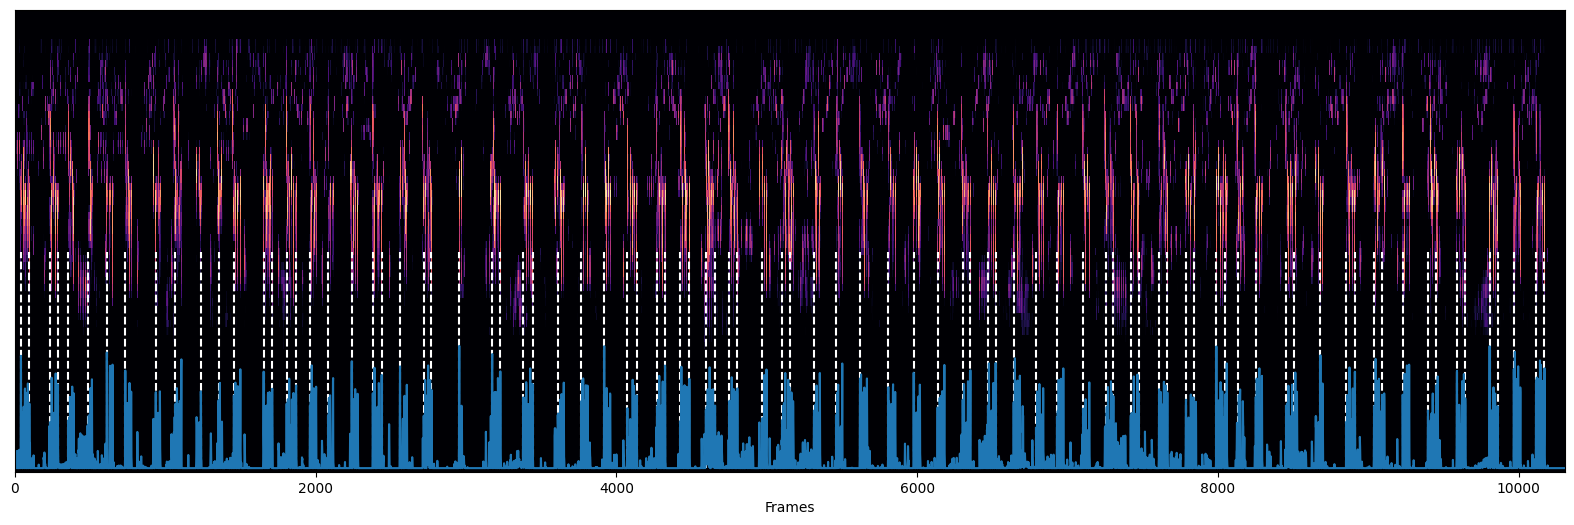

In [166]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)

def f_high(y,sr, freq):
    b,a = signal.butter(10, freq/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf
yf1 = f_high(y, sr)

reduced_noise = nr.reduce_noise(y = yf1, sr=sr, n_std_thresh_stationary=2.0,stationary=True)
F, f_names = ShortTermFeatures.feature_extraction(reduced_noise, sr, 512, 512)


#Plot a spectrogram to see what the audio sounds look like
S1 = librosa.feature.melspectrogram(y=reduced_noise, sr=sr, n_mels=64, n_fft=2048, hop_length=512)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, ax = ax,  x_axis='frames')
#ax.plot(F[5]*64/F[5].max())



diff = np.diff(F[5])

onset_env = librosa.onset.onset_strength(y=reduced_noise, sr=sr, fmax=4000, aggregate=np.mean)
ax.plot(onset_env*2)
peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=2.0, wait=50)

print(peaks)
ax.vlines(peaks, 0, 30 , linestyle='dashed', color = 'white')
ax.label_outer()
#ax.plot(F[5]*64/F[5].max())

#ax2.margins(0)

In [167]:
print(librosa.frames_to_samples(peaks))

[  20480   49152  119296  145920  182272  247296  312832  375808  479744
  543744  632832  693248  745472  846848  876032  925184  957440 1004544
 1066496 1146880 1218560 1248768 1311232 1392128 1418240 1512960 1625088
 1652736 1730560 1762304 1849856 1928192 2006528 2085376 2116608 2186240
 2213376 2266112 2296320 2352640 2383872 2433024 2459648 2544640 2612736
 2640384 2720768 2797056 2877440 2973696 3060224 3141632 3227136 3253248
 3313152 3339264 3400704 3478016 3548160 3637760 3714048 3740160 3799552
 3826176 3895808 3923968 3987456 4016128 4090880 4121088 4163584 4225024
 4328448 4356096 4445184 4533760 4562432 4627968 4655104 4725248 4811264
 4839424 4910080 4938240 5021184 5048320 5103616 5179392 5208064]


In [195]:
def f_high(y,sr, freq):
    b,a = signal.butter(10, freq/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf


def file_cleaning_pipeline(file) -> list:
    y, sr = librosa.load(file)
    # high pass filtering to remove mic noise
    yf1 = f_high(y, sr, 1000)
    # noise filtering using noisereduce package https://pypi.org/project/noisereduce/
    reduced_noise = nr.reduce_noise(y = yf1, sr=sr, n_std_thresh_stationary=2.0,stationary=True)
    # determine onset strengths across the audio file
    onset_env = librosa.onset.onset_strength(y=reduced_noise, sr=sr, fmax=4000, aggregate=np.mean)
    # find the onset peaks
    peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=2.0, wait=50)
    return peaks



# Iterate through local folder
def split_audio_in_folders(local, dest, seconds):

    for local_folder in glob.glob(local + '/**'):
        folder_name =  os.path.basename(local_folder)
        folder_path = os.path.join(dest, folder_name)
        os.mkdir(path)
        print("folder " + folder_path + " created")
        for local_file in glob.glob(local_folder + '/**'):
            file_name = os.path.basename(local_file).split('.')[0]
            ext = os.path.basename(local_file).split('.')[1]
            onset_frames = file_cleaning_pipeline(local_file)
            # Find onset starting samples
            onset_samples = librosa.frames_to_samples(onset_frames)
            end = 0

            for i in range(len(onset_samples)):
                
                # start the clip 5 frames before the onset detection frame
                start = max(onset_samples[i] - (512*5), 0)
                if start < end:
                    continue
                end = start + (sr*seconds)

                segment = y[start: end]

                path = os.path.join(dest, folder_name, file_name+"-"+str(i)+ "."+ ext)
                print(path)

                sf.write(path, segment, sr)
                        
                

In [199]:
# location of files stored locally
local_path = r'C:\Users\Tony\Documents\PEData\3_Dataset_PE_2'
dest_path = r'C:\Users\Tony\Documents\PEData\3_Dataset_PE_4' 
split_audio_in_folders(local_path, dest_path, 5)

C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00001-0.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00002-0.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00002-3.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00002-4.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00003-0.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00003-2.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00003-5.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00003-9.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00003-10.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00004-0.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00004-1.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegotheles Cristatus\00004-2.wav
C:\Users\Tony\Documents\PEData\3_Dataset_PE_4\Aegot